In [54]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1): # функция, для создания двух рядов, в котором находятся данные X(t) и Y(t+lookback)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [55]:
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('D://Downloads//100.csv', usecols=[1], engine='python') # загружаем файл
dataset = dataframe.values #преобразование в массив значений
dataset = dataset.astype('float32') #преобразование данных к указанному типу

In [56]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #масштабирование данных
dataset = scaler.fit_transform(dataset)  #нормализуем данные (приводим их в массив со значениями от 0 до 1)

# split into train and test sets
dataset = dataset[0:10000] # задаем длину датасета
train_size = int(len(dataset) * 0.67) #выбираем размер тренировочной выборки в процентах от всего объема датасета (67%)
test_size = len(dataset) - train_size #оставшуюся часть данных относим к тестовой выборке
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:] # формируем массивы train и test

In [57]:
# reshape into X=t and Y=t+1
look_back = 1 # задаем размер так называемого скользящего окна (насколько мы будем смотреть назад)
trainX, trainY = create_dataset(train, look_back) 
testX, testY = create_dataset(test, look_back)# создаем датасет для нейронки, где X=t and Y=t+look_back

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1)) # меняем размер так, чтобы применить LSTM 
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) # меняем размер так, чтобы применить LSTM 

In [58]:
# create and fit the LSTM network
model = Sequential() # Создание последовательной модели
model.add(LSTM(4, input_shape=(trainX.shape[1], 1))) # добавляем слой с количеством нейронов (узлов) 4 и заданной формы входных данных
model.add(Dense(1)) # добавляем выходной слой с количеством нейронов (узлов) 1
model.compile(loss='mean_squared_error', optimizer='adam') # компилируем, используя среднеквадратичную ошибку в качестве функции потерь и оптимизатор
model.fit(trainX, trainY, epochs=5, batch_size=2, verbose=2) # Обучение модели на тренировочном наборе данных в течение 5 эпох, 2 выборки и с детализацией прогресса обучения

# make predictions
trainPredict = model.predict(trainX) #делаем предсказание на тренировочной выборке
testPredict = model.predict(testX) #делаем предсказание на тестовой выборке

Epoch 1/5
3349/3349 - 6s - loss: 0.0114 - 6s/epoch - 2ms/step
Epoch 2/5
3349/3349 - 5s - loss: 5.2487e-04 - 5s/epoch - 1ms/step
Epoch 3/5
3349/3349 - 5s - loss: 2.5427e-04 - 5s/epoch - 1ms/step
Epoch 4/5
3349/3349 - 5s - loss: 1.6198e-04 - 5s/epoch - 1ms/step
Epoch 5/5
3349/3349 - 5s - loss: 1.5321e-04 - 5s/epoch - 1ms/step
104/104 [==============================] - 0s 1ms/step


In [59]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)  
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#преобразуем в исходные значения предсказанные данные в тестовой и тренировочной выборках

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))  #считаем среднеквадратичную ошибку в тестовом и тренировочном наборах

Train Score: 9.80 RMSE
Test Score: 10.24 RMSE


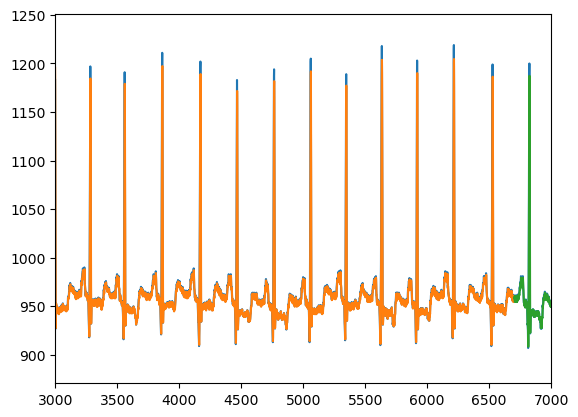

In [60]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict  
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict #предсказания для визуализации тестовой и тренировочной выборок


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset)) #строим графики ура
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim([3000,7000])
plt.show()

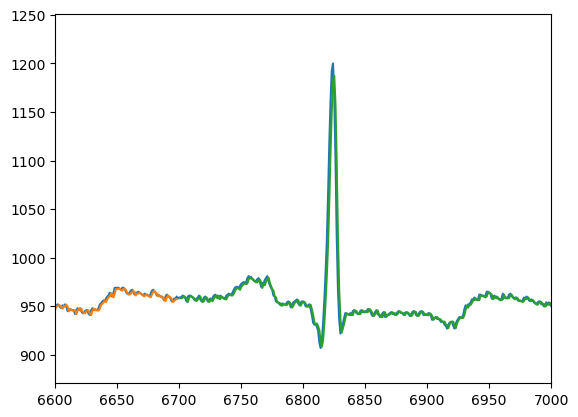

In [62]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim([6600,7000])
plt.show()

Варианты улучшения:
1. Использование нескольких предыдущих значений для прогнозирования следующей точки. То есть на вход подавать данные в момент времени t, t-1, t-2, а получать на выходе t+1 (look_back=3) 
2. Так как временной ряд периодический, то можно на вход для обучения подавать не одномерный ряд, а нарезать весь ряд на промежутки с периодом T. В таком случае получится многомерный входной массив (X(nT))